<a href="https://colab.research.google.com/github/ZahraFayyaz/2021-bordeaux-ODD/blob/main/Markus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#base imports

In [1]:
!pip install Sentencepiece
!pip install transformers #==4.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00


In [2]:
pip install PyQt5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 28.6 MB/s eta 0:00:00


In [3]:
from pathlib import Path

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sentencepiece
from transformers import TFDistilBertForMaskedLM, DistilBertConfig, AdamWeightDecay


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load and prepare training data

In [5]:
# context-less data

train_X = np.load('/content/drive/MyDrive/Data/z_e_z_q_train.npy')
train_y = np.load('/content/drive/MyDrive/Data/z_train_indices.npy')
test_X = np.load('/content/drive/MyDrive/Data/z_e_z_q_test.npy')
test_y = np.load('/content/drive/MyDrive/Data/z_test_indices.npy')


In [6]:
train_X=train_X[..., 1]
test_X=test_X[..., 1]

In [ ]:
print(test_X.shape)
print(train_X.shape)

(10000, 7, 7, 64)
(60000, 7, 7, 64)


In [7]:
#load mnist labels to code
def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train[..., None] / 255., y_train), (x_test[..., None] / 255., y_test)

#(x_test,train_labels), (y_test, test_labels) = load_data('/content/drive/MyDrive/Data/mnist.npz')
(x_train, y_train), (x_test, y_test) = load_data('/content/drive/MyDrive/Data/mnist.npz')

In [8]:
x_train=np.concatenate((x_train,x_train),axis=0)
x_test=np.concatenate((x_test,x_test),axis=0)
y_train=np.concatenate((y_train,y_train),axis=0)
y_test=np.concatenate((y_test,y_test),axis=0)

In [9]:
train_X = np.concatenate((train_X,train_X),axis=0)
train_y = np.concatenate((train_y,train_y),axis=0)
test_X = np.concatenate((test_X,test_X),axis=0)
test_y = np.concatenate((test_y,test_y),axis=0)

In [10]:
#make two digits
def unison_shuffled_copies(a, b, c, d):
    assert len(a) == len(b)
    assert len(a) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p], d[p]


sh_train_X, sh_train_y, sh_x_train, sh_y_train = unison_shuffled_copies(train_X, train_y,x_train,y_train)
sh_test_X, sh_test_y,sh_x_test, sh_y_test = unison_shuffled_copies(test_X, test_y,x_test, y_test)

all_train_x = np.concatenate((train_X,sh_train_X), axis=2)
all_train_y = np.concatenate((train_y, sh_train_y),axis=2)

all_test_x = np.concatenate((test_X,sh_test_X), axis=2)
all_test_y = np.concatenate((test_y, sh_test_y),axis=2)

all_x_train= np.concatenate((x_train,sh_x_train), axis=2)
#all_y_train= np.concatenate((y_train,sh_y_train), axis=1)

all_x_test= np.concatenate((x_test,sh_x_test), axis=2)
#all_y_test= np.concatenate((y_test,sh_y_test), axis=1)

print(all_train_x.shape)

(120000, 7, 14, 64)


In [ ]:
#all_y.shapen_train_samples
#train_y.shape


# one hot encoding

(array([1164., 1335., 1152., 1220., 1147., 1084., 1175., 1256., 1161.,
        1152., 1348., 1495., 1250., 1383., 1262., 1237., 1372., 1437.,
        1322., 1378., 1148., 1380., 1243., 1242., 1173., 1051., 1116.,
        1257., 1148., 1158., 1248., 1389., 1220., 1266., 1204., 1149.,
        1164., 1269., 1171., 1182., 1145., 1334., 1153., 1144., 1128.,
        1083., 1149., 1171., 1180., 1197., 1083., 1270., 1057., 1127.,
        1071.,  950., 1039., 1062., 1074., 1109., 1177., 1317., 1226.,
        1157., 1175., 1057., 1188., 1299., 1105., 1135., 1189., 1403.,
        1276., 1282., 1177., 1153., 1240., 1344., 1217., 1249., 1168.,
        1295., 1187., 1228., 1132.,  999., 1184., 1201., 1162., 1146.,
        1176., 1266., 1152., 1213., 1215., 1079., 1209., 1234., 1162.,
        1192.]),
 array([ 0.  ,  0.99,  1.98,  2.97,  3.96,  4.95,  5.94,  6.93,  7.92,
         8.91,  9.9 , 10.89, 11.88, 12.87, 13.86, 14.85, 15.84, 16.83,
        17.82, 18.81, 19.8 , 20.79, 21.78, 22.77, 23.76, 24.

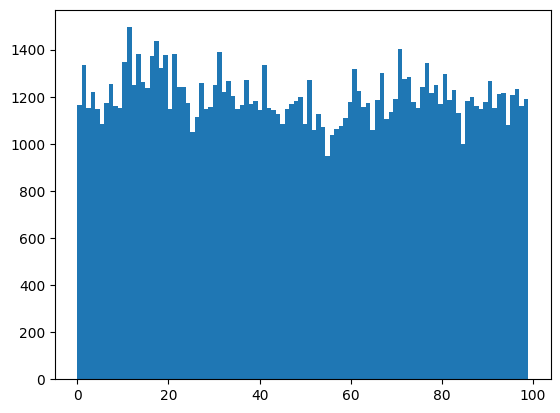

In [11]:
#label=np.concatenate((train_labels,sh_train_labels))
label=np.array(10*y_train+sh_y_train)
test_label=np.array(10*y_test+sh_y_test)
plt.hist(label,100)

In [12]:
#
train_onehot = 2*(tf.keras.utils.to_categorical(y_train, num_classes = 10))-1
test_onehot = 2*(tf.keras.utils.to_categorical(y_test, num_classes = 10))-1

train_expanded = np.repeat(train_onehot[:, np.newaxis,:], 49, axis=1)
test_expanded = np.repeat(test_onehot[:, np.newaxis,:], 49, axis=1)

In [13]:
sh_train_onehot = 2*(tf.keras.utils.to_categorical(sh_y_train, num_classes = 10))-1
sh_test_onehot = 2*(tf.keras.utils.to_categorical(sh_y_test, num_classes = 10))-1

sh_train_expanded = np.repeat(sh_train_onehot[:, np.newaxis,:], 49, axis=1)
sh_test_expanded = np.repeat(sh_test_onehot[:, np.newaxis,:], 49, axis=1)

In [14]:
sh_train_expanded.shape
all_train_expanded=np.concatenate((train_expanded,sh_train_expanded),axis=1)
all_test_expanded=np.concatenate((test_expanded,sh_test_expanded),axis=1)

In [15]:
n_train_samples, n_test_samples = all_train_x.shape[0], all_test_x.shape[0]
d_embed_vec = all_train_x.shape[3]
n_tokens = np.prod(all_train_x.shape[1:3])

# flatten out x/y dimensions and select quantized vectors
train_x = all_train_x.reshape((n_train_samples, n_tokens, d_embed_vec))
train_y = all_train_y.reshape((n_train_samples, n_tokens))
test_x = all_test_x.reshape((n_test_samples, n_tokens, d_embed_vec))
test_y = all_test_y.reshape((n_test_samples, n_tokens))


print(f'Train data shape: {all_train_x.shape}')
print(f'Test data shape: {all_test_x.shape}')

# find largest codebook index for vocabulary size
indices = set(all_train_y.flatten()).union(set(test_y.flatten()))
indices = sorted(indices)
vocab_size = indices[-1] + 1

Train data shape: (120000, 7, 14, 64)
Test data shape: (20000, 7, 14, 64)


# Mask training data

In [16]:
mask_perc = 0.4
mask_token = 0  # does 0 make sense?

mask_train = np.random.default_rng().choice([True, False], size=(n_train_samples, n_tokens), p=[mask_perc, 1 - mask_perc])
mask_test = np.random.default_rng().choice([True, False], size=(n_test_samples, n_tokens), p=[mask_perc, 1 - mask_perc])

masked_train_x = np.copy(train_x)
masked_train_x[mask_train] = mask_token
masked_test_x = np.copy(test_x)
masked_test_x[mask_test] = mask_token

#print(masked_train_X[0])
#print(masked_test_X[0])
np.save('mask_train.npy', mask_train)
np.save('mask_test.npy', mask_test)

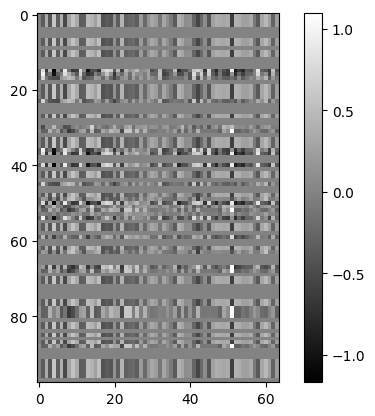

In [17]:
#%matplotlib qt
plt.imshow(masked_train_x[500],cmap='gray')
plt.colorbar()


In [19]:
#conditional data now stacked on top of eavh other

masked_exp_train_x = np.concatenate((all_train_expanded, masked_train_x ),axis=2)
masked_exp_test_x = np.concatenate((all_test_expanded, masked_test_x ),axis=2)

#exp_train_y = np.concatenate((train_onehot, train_y ),axis=1)
#exp_test_y = np.concatenate((test_onehot, test_y ),axis=1)

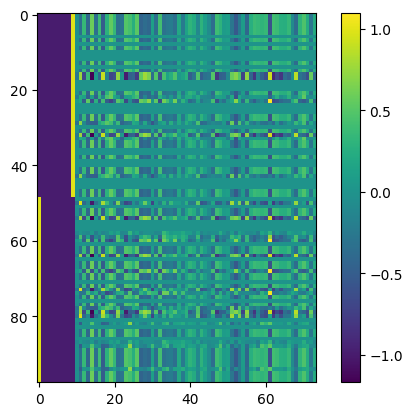

In [ ]:
plt.imshow(masked_exp_train_x[520])
plt.colorbar()

# Prepare transformer

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [20]:
d_batch = 256
n_epochs = 5
n_warmup_epochs = 10
lr = 0.001

cfg = DistilBertConfig(
    vocab_size=vocab_size,
    hidden_size=d_embed_vec+10,
    num_hidden_layers=4,
    num_attention_heads=2,
    intermediate_size=2048,
    max_position_embeddings=n_tokens
)


class LinearScheduleWithWarmup(tf.keras.optimizers.schedules.LearningRateSchedule):
    # How the schedule looks:
    # https://huggingface.co/transformers/v3.0.2/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup
    # or look at plot in testing section

    def __init__(self, learning_rate, n_warmup_epochs, n_train_samples, n_epochs, d_batch):
        self.learning_rate = tf.convert_to_tensor(learning_rate, dtype=tf.float32)
        self.n_warmup_epochs = tf.convert_to_tensor(n_warmup_epochs, dtype=tf.float32)
        self.n_train_samples = tf.convert_to_tensor(n_train_samples, dtype=tf.float32)
        self.n_epochs = tf.convert_to_tensor(n_epochs, dtype=tf.float32)
        self.d_batch = tf.convert_to_tensor(d_batch, dtype=tf.float32)

        self.steps_per_epoch = tf.convert_to_tensor(round(n_train_samples / d_batch), dtype=tf.float32)
        self.total_steps = tf.convert_to_tensor(self.steps_per_epoch * n_epochs, dtype=tf.float32)
        self.b = self.learning_rate * self.n_epochs / (self.n_epochs - self.n_warmup_epochs)

    def __call__(self, step):
        def true_fn():
            return self.learning_rate / self.n_warmup_epochs * step / self.steps_per_epoch
        def false_fn():
            return - self.learning_rate / (self.n_epochs - self.n_warmup_epochs) * (step / self.steps_per_epoch) + self.b

        ret = tf.cond(step / self.steps_per_epoch < self.n_warmup_epochs, true_fn, false_fn)
        return ret


model = TFDistilBertForMaskedLM(cfg)
lr_schedule = LinearScheduleWithWarmup(lr, n_warmup_epochs, n_train_samples, n_epochs, d_batch)
optimizer = AdamWeightDecay(lr=lr)#learning_rate=lr_schedule)

model.compile(optimizer=optimizer)

model({'inputs_embeds': masked_exp_train_x[0, None], 'labels': train_y[0, None]})  # call model once with some input to get it built so we can do model.summary()
model.summary()

Model: "tf_distil_bert_for_masked_lm_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 distilbert (TFDistilBertMa  multiple                  1930072   
 inLayer)                                                        
                                                                 
 vocab_transform (Dense)     multiple                  5550      
                                                                 
 vocab_layer_norm (LayerNor  multiple                  148       
 malization)                                                     
                                                                 
 vocab_projector (TFDistilB  multiple                  8900      
 ertLMHead)                                                      
                                                                 
Total params: 1935790 (7.38 MB)
Trainable params: 1935790 (7.38 MB)
Non-trainable params: 0 (0.00 Byte

# Train

In [21]:
model.load_weights('/content/drive/MyDrive/markus2')

In [22]:
weights_file_name = 'distilBERT_weights_conditional'
checkpoint_dir_name = 'mdl_checkpoints'

#if Path('distilBERT_weights').is_file():
#    load_status = model.load_weights('distilBERT_weights')
#    print('Continue training of pretrained model')

cpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=f'./{checkpoint_dir_name}/', save_weights_only=True, verbose=1)

# TODO: should we only penalize the reconstructed tokens in the loss and ignore the rest?
model.fit({'inputs_embeds': masked_exp_train_x, 'labels': train_y},
          batch_size=d_batch,
          epochs=n_epochs,
          validation_data={'inputs_embeds': masked_exp_test_x, 'labels': test_y},
          #callbacks=[cpt_callback]
          )

model.save_weights('/content/drive/MyDrive/markus3', save_format='h5')


Epoch 1/5
469/469 [==============================] - 1940s 4s/step - loss: 0.3406 - val_loss: 0.3097
Epoch 2/5
469/469 [==============================] - 1923s 4s/step - loss: 0.3159 - val_loss: 0.2863
Epoch 3/5
469/469 [==============================] - 1937s 4s/step - loss: 0.2964 - val_loss: 0.2715
Epoch 4/5
469/469 [==============================] - 1903s 4s/step - loss: 0.2828 - val_loss: 0.2591
Epoch 5/5
469/469 [==============================] - 1930s 4s/step - loss: 0.2733 - val_loss: 0.2522


In [ ]:
model.save_weights('/content/drive/MyDrive/markus2', save_format='h5')

NameError: ignored

In [ ]:
#model.save_weights('/content/drive/MyDrive/distilBERT_weights', save_format='h5')

# Reconstruct patterns with train attention

In [ ]:
n_rec = 100 #n_test_samples

# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions = model.predict({'inputs_embeds': masked_exp_test_x[:n_rec].astype('float32'), 'labels': test_y[:n_rec].astype('float32')}, batch_size=256)

logits = reconstructions.logits
most_probable = logits.argmax(axis=-1)

#np.save(f'reconstructions_test_{n_rec}_samples.npy', most_probable)

1/1 [==============================] - 5s 5s/step


In [ ]:
print(most_probable[12])

[ 7  7  7  7  7  7  7  7  7  7 13 13  7  7  7  7 13 13 13  7  7  7  7 13
 13 13  7  7  7  7 13 13 13  7  7  7  7 13 13  7  7  7  7  7  7  7  7  7
  7]


# Load VQ-VAE to decode results

In [ ]:
import tensorflow.keras as K
from tensorflow.keras import backend as Kb
import matplotlib.pyplot as plt
from keras.models import load_model


def load_data(path):
    with np.load(path) as f:
        x_train, y_train = f['x_train'], f['y_train']
        x_test, y_test = f['x_test'], f['y_test']
        return (x_train[..., None] / 255., y_train), (x_test[..., None] / 255., y_test)

#(x_train, y_train), (x_test, y_test) = load_data('/content/drive/MyDrive/Data/mnist.npz')

# Hyperparameters
NUM_LATENT_K = 20                 # Number of codebook entries
NUM_LATENT_D = 64                 # Dimension of each codebook entries
BETA = 1.0                        # Weight for the commitment loss

INPUT_SHAPE = x_train.shape[1:]
SIZE = None                       # Spatial size of latent embedding
                                  # will be set dynamically in `build_vqvae

VQVAE_BATCH_SIZE = 128            # Batch size for training the VQVAE
VQVAE_NUM_EPOCHS = 20             # Number of epochs
VQVAE_LEARNING_RATE = 3e-4        # Learning rate
VQVAE_LAYERS = [16, 32]           # Number of filters for each layer in the encoder

PIXELCNN_BATCH_SIZE = 128         # Batch size for training the PixelCNN prior
PIXELCNN_NUM_EPOCHS = 10          # Number of epochs
PIXELCNN_LEARNING_RATE = 3e-4     # Learning rate
PIXELCNN_NUM_BLOCKS = 12          # Number of Gated PixelCNN blocks in the architecture
PIXELCNN_NUM_FEATURE_MAPS = 32    # Width of each PixelCNN block


# # Building the generative model
#
# The first step is to build the main VQ-VAE model. It consists of a standard encoder-decoder architecture with convolutional blocks. The main novelty lies in the intermediate **Vector Quantizer** layer (`VQ`) that takes care of building a **discrete** latent space.
#
# More specifically, the encoder, `f` is a fully-convolutional neural network that maps input images to latent codes of size $(w, h, d)$, where $d$ is the dimension of the latent space, and $w \times h$ the size of the final feature map. The output of the encoder is then mapped to the closest entry in a discrete **codebook** of $K$ latent codes, $\mathcal E = \{e_0 \dots e_{K-1} \}$ where $\forall i, e_i \in \mathbb{R}^d$.
#
# \begin{align}
# &\textbf{input }x \tag{W x H x C}\\
# z_e &= f(x) \tag{w x h x d}\\
# z_q^{i, j} &= \arg\min_{e \in \mathcal E} \| z_e^{i, j} - e \|^2
# \end{align}
#
# The Vector Quantization process is implemented as the following `Keras` Layer:

# In[7]:


class VectorQuantizer(K.layers.Layer):
    def __init__(self, k, **kwargs):
        super(VectorQuantizer, self).__init__(**kwargs)
        self.k = k

    def build(self, input_shape):
        self.d = int(input_shape[-1])
        rand_init = K.initializers.VarianceScaling(distribution="uniform")
        self.codebook = self.add_weight(shape=(self.k, self.d), initializer=rand_init, trainable=True)

    def call(self, inputs):
        # Map z_e of shape (b, w,, h, d) to indices in the codebook
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        z_e = tf.expand_dims(inputs, -2)
        dist = tf.norm(z_e - lookup_, axis=-1)
        k_index = tf.argmin(dist, axis=-1)
        return k_index

    def sample(self, k_index):
        # Map indices array of shape (b, w, h) to actual codebook z_q
        lookup_ = tf.reshape(self.codebook, shape=(1, 1, 1, self.k, self.d))
        k_index_one_hot = tf.one_hot(k_index, self.k)
        z_q = lookup_ * k_index_one_hot[..., None]
        z_q = tf.reduce_sum(z_q, axis=-2)
        return z_q


# The decoder, $g$, then takes the quantized codes $z_q$ as inputs and generates the output image. Here we consider a simple architecture with transposed convolution blocks, mirroring the encoder architecture:

# In[8]:


def encoder_pass(inputs, d, num_layers=[16, 32]):
    x = inputs
    for i, filters in enumerate(num_layers):
        x = K.layers.Conv2D(filters=filters, kernel_size=3, padding='SAME', activation='relu',
                            strides=(2, 2), name="conv{}".format(i + 1))(x)
    z_e = K.layers.Conv2D(filters=d, kernel_size=3, padding='SAME', activation=None,
                          strides=(1, 1), name='z_e')(x)
    return z_e

def decoder_pass(inputs, num_layers=[32, 16]):
    y = inputs
    for i, filters in enumerate(num_layers):
        y = K.layers.Conv2DTranspose(filters=filters, kernel_size=4, strides=(2, 2), padding="SAME",
                                     activation='relu', name="convT{}".format(i + 1))(y)
    decoded = K.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=(1, 1),
                                       padding="SAME", activation='sigmoid', name='output')(y)
    return decoded


# Once these three building blocks are done, we can build the full `VQ-VAE`. One subtility is how we can estimate gradient through the Vector Quantizer: In fact, the transition from $z_e$ to $z_q$ does not allow to backpropagate gradient due to the argmin function. Instead, the authors propose to use a *straight-through estimator*, that directly copies the gradient received by $z_q$ to $z_e$.

# In[9]:


def build_vqvae(k, d, input_shape=(28, 28, 1), num_layers=[16, 32]):
    global SIZE
    ## Encoder
    encoder_inputs = K.layers.Input(shape=input_shape, name='encoder_inputs')
    z_e = encoder_pass(encoder_inputs, d, num_layers=num_layers)
    SIZE = int(z_e.get_shape()[1])

    ## Vector Quantization
    vector_quantizer = VectorQuantizer(k, name="vector_quantizer")
    codebook_indices = vector_quantizer(z_e)
    encoder = K.Model(inputs=encoder_inputs, outputs=codebook_indices, name='encoder')

    ## Decoder
    decoder_inputs = K.layers.Input(shape=(SIZE, SIZE, d), name='decoder_inputs')
    decoded = decoder_pass(decoder_inputs, num_layers=num_layers[::-1])
    decoder = K.Model(inputs=decoder_inputs, outputs=decoded, name='decoder')

    ## VQVAE Model (training)
    sampling_layer = K.layers.Lambda(lambda x: vector_quantizer.sample(x), name="sample_from_codebook")
    z_q = sampling_layer(codebook_indices)
    codes = tf.stack([z_e, z_q], axis=-1)
    codes = K.layers.Lambda(lambda x: x, name='latent_codes')(codes)
    straight_through = K.layers.Lambda(lambda x : x[1] + tf.stop_gradient(x[0] - x[1]), name="straight_through_estimator")
    straight_through_zq = straight_through([z_q, z_e])
    reconstructed = decoder(straight_through_zq)
    vq_vae = K.Model(inputs=encoder_inputs, outputs=[reconstructed, codes], name='vq-vae')

    ## VQVAE model (inference)
    codebook_indices = K.layers.Input(shape=(SIZE, SIZE), name='discrete_codes', dtype=tf.int32)
    z_q = sampling_layer(codebook_indices)
    generated = decoder(z_q)
    vq_vae_sampler = K.Model(inputs=codebook_indices, outputs=generated, name='vq-vae-sampler')

    ## Transition from codebook indices to model (for training the prior later)
    indices = K.layers.Input(shape=(SIZE, SIZE), name='codes_sampler_inputs', dtype='int32')
    z_q = sampling_layer(indices)
    codes_sampler = K.Model(inputs=indices, outputs=z_q, name="codes_sampler")

    ## Getter to easily access the codebook for vizualisation
    indices = K.layers.Input(shape=(), dtype='int32')
    vector_model = K.Model(inputs=indices, outputs=vector_quantizer.sample(indices[:, None, None]), name='get_codebook')
    def get_vq_vae_codebook():
        codebook = vector_model.predict(np.arange(k))
        codebook = np.reshape(codebook, (k, d))
        return codebook

    return vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook

vq_vae, vq_vae_sampler, encoder, decoder, codes_sampler, get_vq_vae_codebook = build_vqvae(
    NUM_LATENT_K, NUM_LATENT_D, input_shape=INPUT_SHAPE, num_layers=VQVAE_LAYERS)
vq_vae.summary()

def mse_loss(ground_truth, predictions):
    mse_loss = tf.reduce_mean((ground_truth - predictions)**2, name="mse_loss")
    return mse_loss

def latent_loss(dummy_ground_truth, outputs):
    global BETA
    del dummy_ground_truth
    z_e, z_q = tf.split(outputs, 2, axis=-1)
    vq_loss = tf.reduce_mean((tf.stop_gradient(z_e) - z_q)**2)
    commit_loss = tf.reduce_mean((z_e - tf.stop_gradient(z_q))**2)
    latent_loss = tf.identity(vq_loss + BETA * commit_loss, name="latent_loss")
    return latent_loss
vq_vae.load_weights('/content/drive/MyDrive/Data/vq20_ws.h5')


The following Variables were used a Lambda layer's call (sample_from_codebook), but
are not present in its tracked objects:
  <tf.Variable 'vector_quantizer/Variable:0' shape=(20, 64) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.


Model: "vq-vae"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_inputs (InputLayer  [(None, 28, 28, 1)]          0         []                            
 )                                                                                                
                                                                                                  
 conv1 (Conv2D)              (None, 14, 14, 16)           160       ['encoder_inputs[0][0]']      
                                                                                                  
 conv2 (Conv2D)              (None, 7, 7, 32)             4640      ['conv1[0][0]']               
                                                                                                  
 z_e (Conv2D)                (None, 7, 7, 64)             18496     ['conv2[0][0]']          

# Plot results

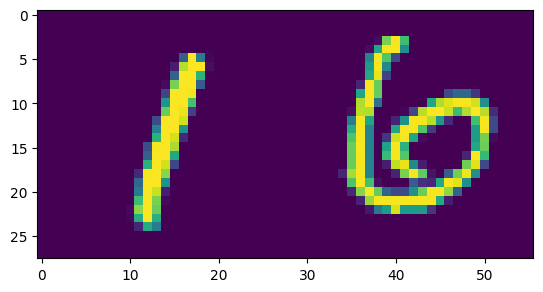

In [ ]:
i=5
plt.imshow(all_x_test[i,:,:,0])

1/1 [==============================] - 0s 22ms/step
0.06807547 0.18640049


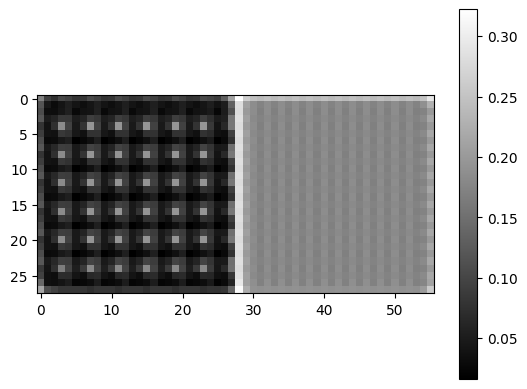

In [ ]:
i=5
codes=all_test_y
codes1=np.zeros((10,7,7))
codes2=-np.ones((10,7,7))
zq1 = codes_sampler(codes1)
zq2 = codes_sampler(codes2)
decoded1 = decoder.predict(zq1, steps=1)
decoded2 = decoder.predict(zq2, steps=1)
plt.imshow(np.concatenate((decoded1[i,:,:,0],decoded2[i,:,:,0]),axis=1),cmap='gray')
plt.colorbar()
print(np.average(decoded1),np.average(decoded2))

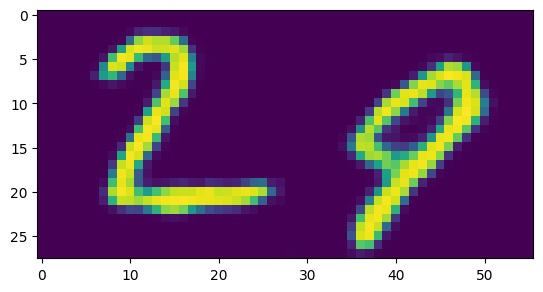

In [ ]:
plt.imshow(np.concatenate((decoded1[i,:,:,0],decoded2[i,:,:,0]),axis=1))

In [ ]:
test_label[0:10]

array([75, 29, 15,  9, 46, 17, 42, 96, 53, 91], dtype=uint8)

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
​
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


SyntaxError: ignored

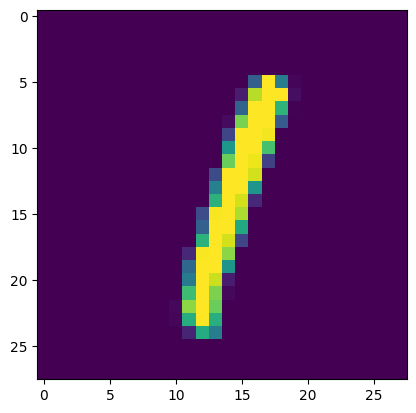

In [ ]:
i=5
plt.imshow(x_test[i,:,:,0])

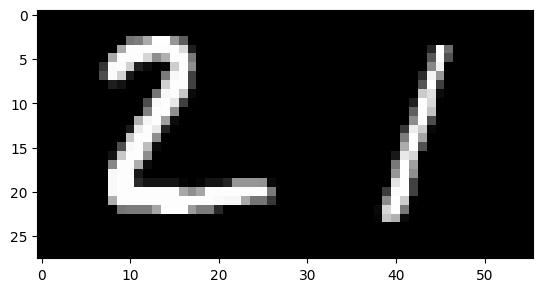

In [ ]:
plt.imshow(np.concatenate((x_test[1],x_test[2]),axis=1),cmap='gray')

1/1 [==============================] - 0s 36ms/step


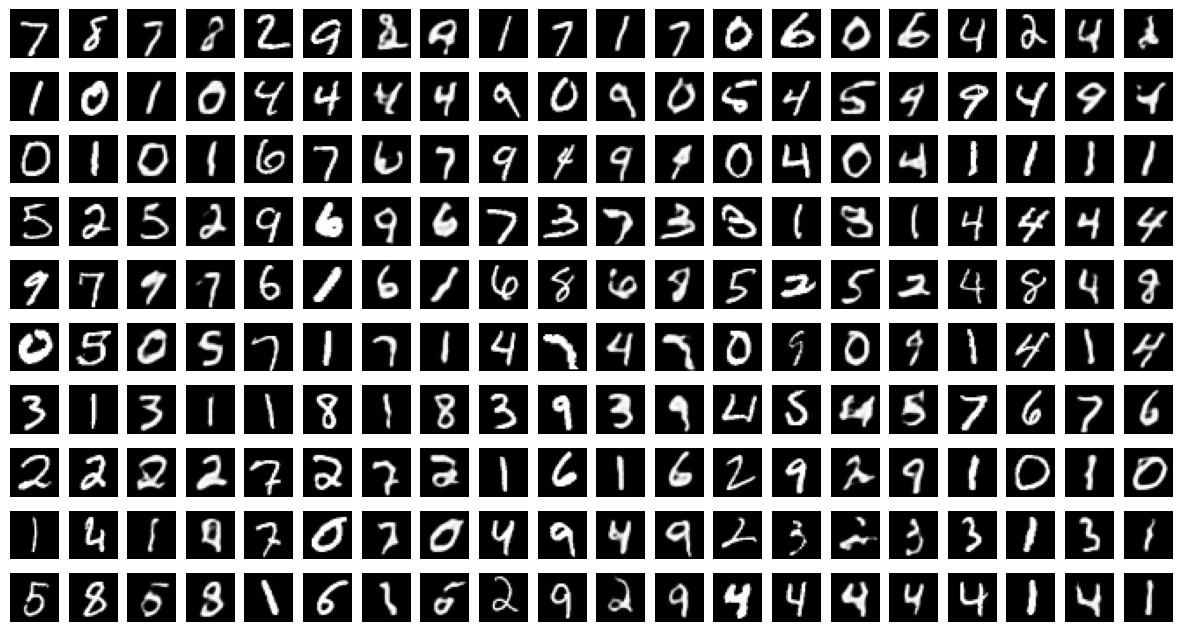

In [ ]:
def decode(codes, codes_sampler,all_x_test, size, n_row, n_col):
    """plot decoded codes"""
    n = n_col * n_row
    codes1=codes[:,:,:7]
    codes2=codes[:,:,7:]
    zq1 = codes_sampler(codes1)
    zq2 = codes_sampler(codes2)
    decoded1 = decoder.predict(zq1, steps=1)
    decoded2 = decoder.predict(zq2, steps=1)
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 4 * n_col, 4 * i + 1)
        plt.imshow(all_x_test[i,:,:28,0], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 4 * n_col, 4 * i + 2)
        plt.imshow(all_x_test[i,:,28:,0], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 4 * n_col, 4 * i + 3)
        plt.imshow(decoded1[i,:,:,0], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 4 * n_col, 4 * i + 4)
        plt.imshow(decoded2[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()


tzq= most_probable
tzq= tzq[:,:98].reshape([n_rec,7,14])

decode(tzq,codes_sampler,all_x_test[:100,:,:,:], 100,10,5)

In [ ]:
def decode(codes, codes_sampler,all_x_test, size, n_row, n_col):
    """plot decoded codes"""
    n = n_col * n_row
    codes1=codes[:,:,:7]
    codes2=codes[:,:,7:]
    zq1 = codes_sampler(codes1)
    zq2 = codes_sampler(codes2)
    decoded1 = decoder.predict(zq1, steps=1)
    decoded2 = decoder.predict(zq2, steps=1)
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 4 * n_col, 4 * i + 1)
        plt.imshow(all_x_test[i,:,:28,0], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 4 * n_col, 4 * i + 2)
        plt.imshow(all_x_test[i,:,28:,0], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 4 * n_col, 4 * i + 3)
        plt.imshow(decoded1[i,:,:,0], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 4 * n_col, 4 * i + 4)
        plt.imshow(decoded2[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()


tzq= most_probable
tzq= tzq[:,:98].reshape([n_rec,7,14])

decode(tzq,codes_sampler,all_x_test[:100,:,:,:], 100,10,5)

In [ ]:
## print train data
n_rec = 100 #n_test_samples

# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions = model.predict({'inputs_embeds': masked_exp_train_x[:n_rec].astype('float32'), 'labels': train_y[:n_rec].astype('float32')}, batch_size=256)

logits = reconstructions.logits
most_probable_train = logits.argmax(axis=-1)


1/1 [==============================] - 2s 2s/step


1/1 [==============================] - 0s 34ms/step


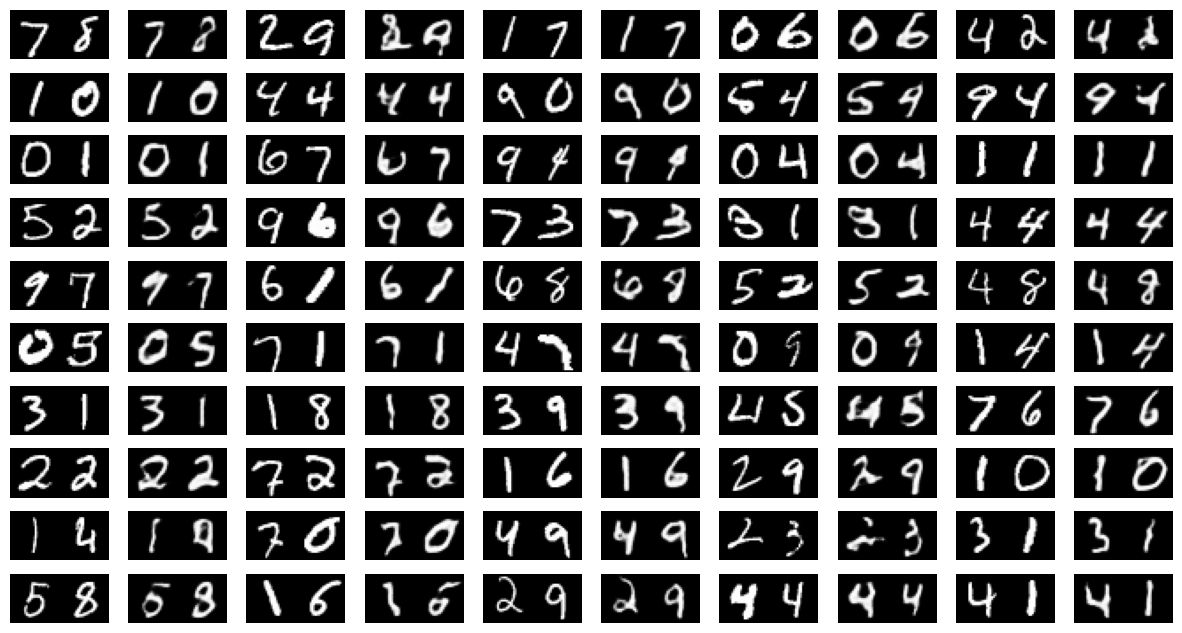

In [ ]:
def decode(codes, codes_sampler,x_test, size, n_row, n_col):
    """plot decoded codes"""
    n = n_col * n_row
    codes1=codes[:,:,:7]
    codes2=codes[:,:,7:]
    zq1 = codes_sampler(codes1)
    zq2 = codes_sampler(codes2)
    decoded1 = decoder.predict(zq1, steps=1)
    decoded2 = decoder.predict(zq2, steps=1)
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(all_x_test[i], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(np.concatenate((decoded1[i,:,:,0],decoded2[i,:,:,0]), axis=1), cmap='gray')
        plt.axis('off')
    plt.show()


tzq= most_probable
tzq= tzq[:,:98].reshape([n_rec,7,14])

decode(tzq,codes_sampler,all_x_test[:100,:,:,0], 100,10,5)

1/1 [==============================] - 1s 774ms/step


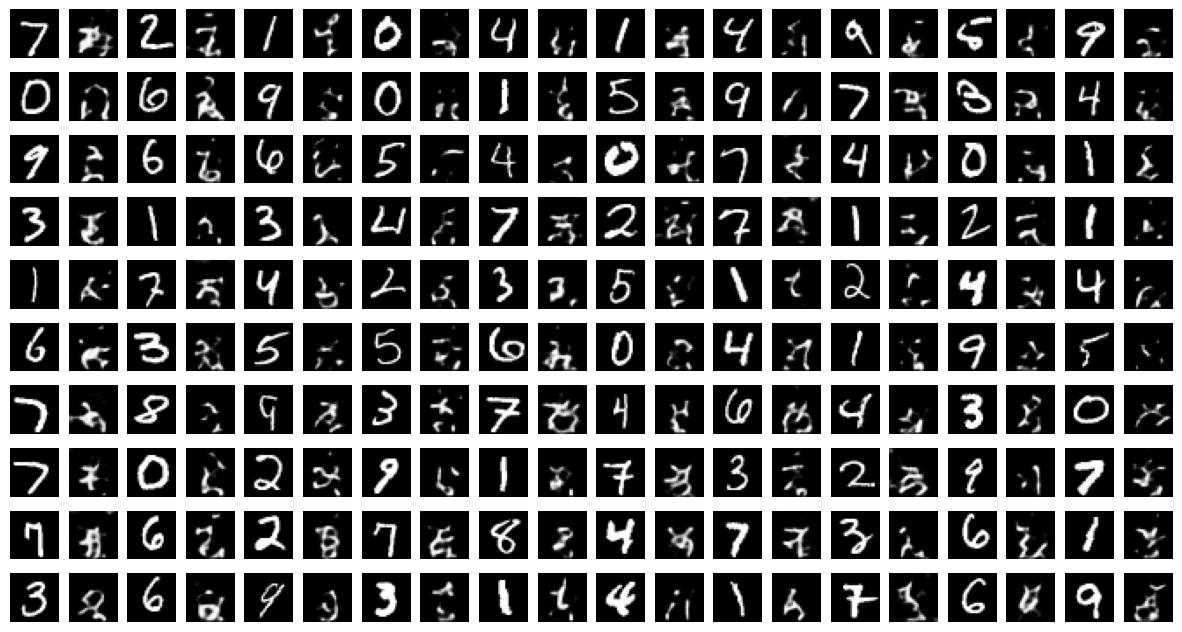

In [ ]:


#helper function for plotting results
def decode(codes, codes_sampler,x_test, size, n_row, n_col):
    """plot decoded codes"""
    n = n_col * n_row
    zq = codes_sampler(codes)
    decoded = decoder.predict(zq, steps=1)
    plt.figure(figsize=(15, 8))
    for i in range(n):
        plt.subplot(n_row, 2 * n_col, 2 * i + 1)
        plt.imshow(x_test[i], cmap='gray')
        plt.axis('off')
        plt.subplot(n_row, 2 * n_col, 2 * i + 2)
        plt.imshow(decoded[i,:,:,0], cmap='gray')
        plt.axis('off')
    plt.show()


tzq= most_probable
tzq= tzq[:,:49].reshape([10000,7,7])

decode(tzq,codes_sampler,x_test[:,:,:,0], 100,10,10)


1/1 [==============================] - 1s 749ms/step


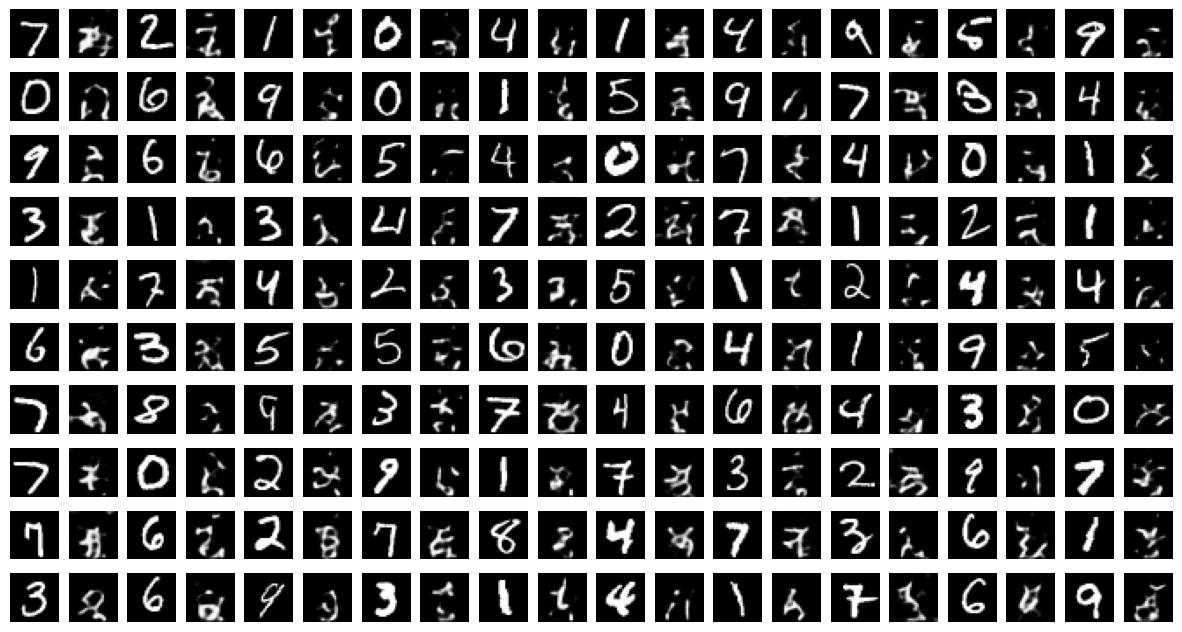

In [ ]:
tzq= most_probable
tzq= tzq[:,:49].reshape([10000,7,7])

decode(tzq,codes_sampler,x_test[:,:,:,0], 100,10,10)


# Reconstruct patterns with varying attention (consistent patterns)

In [ ]:
#load_status = model.load_weights('/content/drive/MyDrive/distilBERT_weights')
#load_status.assert_consumed()

n_rec = n_test_samples

mask_perc = 0.6
mask_token = 0  # does 0 make sense?

mask_test = np.random.default_rng().choice([True, False], size=(n_test_samples, n_tokens), p=[mask_perc, 1 - mask_perc])
masked_test_X = np.copy(test_X)
masked_test_X[mask_test] = mask_token
#np.save(f'mask_test_{mask_perc}.npy', mask_test)

#conditional data
#masked_exp_train_X = np.concatenate((train_expanded, masked_train_X ),axis=2)
#masked_exp_test_X = np.concatenate((test_expanded, masked_test_X ),axis=2)

#exp_train_y = np.concatenate((train_y, train_onehot),axis=1)
#exp_test_y = np.concatenate((test_y, test_onehot),axis=1)
#wrong condition
masked_exp_train_X = np.concatenate((train_expanded, masked_train_X ),axis=2)
masked_exp_test_X = np.concatenate((train_expanded[:10000], masked_test_X ),axis=2)

# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions = model.predict({'inputs_embeds': masked_exp_test_X[:n_rec], 'labels': test_y[:n_rec]}, batch_size=256)

logits = reconstructions.logits
most_probable = logits.argmax(axis=-1)

#np.save(f'reconstructions_test_{n_rec}_samples_{mask_perc}.npy', most_probable)

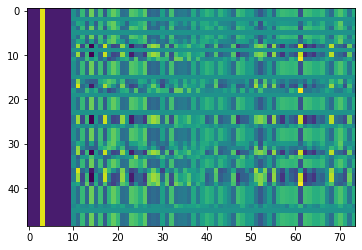

In [ ]:
plt.imshow(masked_exp_test_X[500])

# Reconstruct patterns with varying attention (inconsistent patterns)

In [ ]:
load_status = model.load_weights('/content/drive/MyDrive/distilBERT_weights')

n_rec = n_test_samples

mask_perc = 0.5
mask_token = 0  # does 0 make sense?

mask_test_incon = np.random.default_rng().choice([True, False], size=(n_test_samples, n_tokens), p=[mask_perc, 1 - mask_perc])
masked_test_X = np.copy(test_X_incon)
masked_test_X[mask_test_incon] = mask_token
np.save(f'mask_test_incon_{mask_perc}.npy', mask_test)

# see https://huggingface.co/docs/transformers/main_classes/output#transformers.modeling_outputs.MaskedLMOutput
reconstructions = model.predict({'inputs_embeds': masked_test_X[:n_rec], 'labels': test_y_incon[:n_rec]}, batch_size=256)

logits = reconstructions.logits
most_probable = logits.argmax(axis=-1)

np.save(f'reconstructions_test_incon_{n_rec}_samples_{mask_perc}.npy', most_probable)

NameError: ignored

# Testing Various Things

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
encoded = tokenizer("[MASK]")
print(encoded)
decoded = tokenizer.decode(encoded['input_ids'])
print(decoded)

{'input_ids': [101, 103, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}
[CLS] [MASK] [SEP]


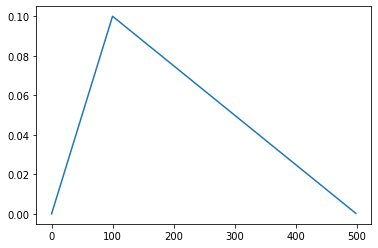

In [ ]:
import matplotlib.pyplot as plt

sched = LinearScheduleWithWarmup(learning_rate=0.1, n_warmup_epochs=1, n_train_samples=1000, n_epochs=5, d_batch=10)
lr_values = [sched(i) for i in range(sched.total_steps.numpy().astype(np.int32))]

plt.plot(lr_values)
plt.show()